[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeljov/NAP2025/blob/main/BBC_News_Clustering_SBERT.ipynb)

# Sentence Embeddings for Document (News) Clustering

This notebook provides an example of text clustering using:
* [SentenceTransformers](https://www.sbert.net/) python library,
* a pre-trained sentence embeddings model, available from the [HuggingFace](https://huggingface.co/models) repository, and
* a hierarchical clustering algorithm.

In addition, the notebook exemplifies the use of the [t-SNE](https://lvdmaaten.github.io/tsne/) dimensionality reduction technique to plot and visually examine documents after transforming them into vectors.

Finally, it shows how a keywords extraction library, in this case [KeyBERT](https://github.com/MaartenGr/KeyBERT), can be used to extract keywords for each cluster, so that we can better understand the documents in individual clusters.<br>

The data used in the example originate from Kaggle' [BBC News](https://www.kaggle.com/datasets/gpreda/bbc-news) dataset.

## Install and import the required libraries

In [1]:
!pip -q install sentence-transformers keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.3 MB/s eta 0:00:00


In [2]:
# a collection of 2500+ palettes curated by experts; https://github.com/y-sunflower/pypalettes

!pip -q install pypalettes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.3/367.3 kB 6.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from pathlib import Path

# module for dimensionality reduction
from sklearn.manifold import TSNE

# modules for clustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

# modules for plotting
import matplotlib.pyplot as plt
import seaborn as sb
from pypalettes import load_cmap

import warnings

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

# for building a sentence embeddings model
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [5]:
# seed value for random processes
RAND_STATE = 1

# A pretrained sentence embeddings model to use
PRETRAINED_LM = "all-MiniLM-L12-v2"

For an overview of pretrained language models offered by HuggingFace, see: [https://www.sbert.net/docs/pretrained_models.html](https://www.sbert.net/docs/pretrained_models.html)

## Load the required resources

Start by loading the data from the 'bbc_news.csv' file:

In [6]:
from google.colab import files

data_file = files.upload()

Saving bbc_news.csv to bbc_news.csv


In [7]:
file_name = list(data_file.keys())[0]
data = pd.read_csv(file_name)

In [8]:
data.head()

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42115 entries, 0 to 42114
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        42115 non-null  object
 1   pubDate      42115 non-null  object
 2   guid         42115 non-null  object
 3   link         42115 non-null  object
 4   description  42115 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


Considering that the dataset is quite large and thus may slow down the data processing steps, we will use in the analysis only a subset of news originating from the same year.

So, we need to extract year from the <pubDate> column and use it for data filtering:

In [10]:
try:
  data['pub_date'] = pd.to_datetime(data.pubDate, format="%a, %d %b %Y %H:%M:%S GMT", errors='raise')
except ValueError as err:
  print(err)

In [11]:
data['pub_year'] = data.pub_date.dt.year
data.pub_year.value_counts()

,count
pub_year,
2023,15043
2024,14761
2022,12301
2021,6
2019,1
2017,1
2013,1
2018,1


Let's focus on a subset of the most recent news - those from 2024. Since this is still fairly large (for efficient processing), we will take a random sample of N=5000 entries

In [12]:
data2024 = data.loc[data.pub_year == 2024,].sample(n=5000, random_state=RAND_STATE).copy()

# drop columns that are no longer needed
data2024.drop(columns=['pub_year', 'pubDate'], inplace=True)

data2024.reset_index(drop=True, inplace=True)

We will merge the `title` and `description` fields to obtain an overall textual content of each news, which we will then use in news processing and clustering.

In [13]:
data2024['content'] = data2024.apply(lambda row: f"{row['title']}. {row['description']}", axis=1)

In [14]:
data2024.head(10)

,title,guid,link,description,pub_date,content
0,Train strikes: What routes are affected when?,https://www.bbc.co.uk/news/business-61634959#8,https://www.bbc.co.uk/news/business-61634959,"Train drivers have been staging strikes, coinc...",2024-05-09 20:48:05,Train strikes: What routes are affected when?....
1,'I'm not Harry Potter' - Ten Hag defends Man U...,https://www.bbc.com/sport/football/articles/cx...,https://www.bbc.com/sport/football/articles/cx...,Manchester United manager Erik ten Hag says he...,2024-09-01 19:16:16,'I'm not Harry Potter' - Ten Hag defends Man U...
2,Thousands more appointments hit by doctor strike,https://www.bbc.co.uk/news/health-68448601#3,https://www.bbc.co.uk/news/health-68448601,"The NHS England said 91,000 appointments and p...",2024-03-01 18:18:26,Thousands more appointments hit by doctor stri...
3,"Labour manifesto all about wealth creation, sa...",https://www.bbc.com/news/articles/clll8d2vd8yo#0,https://www.bbc.com/news/articles/clll8d2vd8yo,"Sir Keir Starmer says there will be ""no surpri...",2024-06-12 23:59:50,"Labour manifesto all about wealth creation, sa..."
4,In defence of Foden - 'this is a tactical issu...,https://www.bbc.com/sport/football/articles/cn...,https://www.bbc.com/sport/football/articles/cn...,BBC pundit Micah Richards argues Phil Foden's ...,2024-07-09 05:18:06,In defence of Foden - 'this is a tactical issu...
5,Train ticket machines charging double online p...,https://www.bbc.co.uk/news/business-68009768,https://www.bbc.co.uk/news/business-68009768?a...,Which? has said the best value fares are eithe...,2024-01-18 10:50:21,Train ticket machines charging double online p...
6,'I didn’t give up the win. I lost it off the l...,https://www.bbc.com/sport/formula1/articles/cy...,https://www.bbc.com/sport/formula1/articles/cy...,Lando Norris agonised over whether to hand vic...,2024-07-21 21:35:38,'I didn’t give up the win. I lost it off the l...
7,Post Office scandal: Minister says he wants to...,https://www.bbc.co.uk/news/uk-67962473,https://www.bbc.co.uk/news/uk-67962473?at_medi...,"Kevin Hollinrake said that people ""must be hel...",2024-01-12 22:36:32,Post Office scandal: Minister says he wants to...
8,'This is mine' - Coleman beats Lyles to 60m gold,https://www.bbc.co.uk/sport/av/athletics/68453...,https://www.bbc.co.uk/sport/av/athletics/68453982,Watch as American Christian Coleman beats comp...,2024-03-01 22:12:58,'This is mine' - Coleman beats Lyles to 60m go...
9,'Hole in the ground' nuclear bunker to go unde...,https://www.bbc.com/news/articles/cvgly74dkjjo#3,https://www.bbc.com/news/articles/cvgly74dkjjo,"""Quirky"" buyer is sought for the nuclear bunke...",2024-10-19 07:05:28,'Hole in the ground' nuclear bunker to go unde...


Check the lenght of the newly created textual column

In [15]:
data2024['content_len'] = data2024.content.apply(lambda c: len(c))
data2024.content_len.describe()

,content_len
count,5000.000000
mean,159.877800
std,27.012849
min,35.000000
25%,145.000000
50%,156.000000
75%,173.000000
max,297.000000


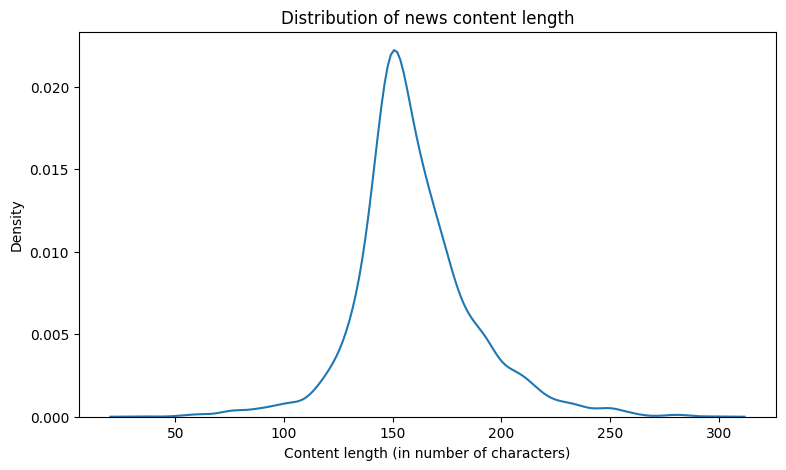

In [16]:
plt.figure(figsize=(9,5))
sb.kdeplot(data=data2024, x='content_len')
plt.title("Distribution of news content length")
plt.xlabel('Content length (in number of characters)')
plt.show()

This indicates that we have rather short texts, which are suitable for [SBERT's original pretrained models](https://www.sbert.net/docs/pretrained_models.html).

#### Getting access to HuggingFace models

Next, we instantiate a sentence embedding model using a pre-trained embeddings model from HuggingFace.

Note: To be able to use models from the HuggingFace repo, one needs a HuggingFace access token. To obtain one, you would, first, need to set up an account at [HuggingFace.co](https://huggingface.co/). After logging in, click on the profile in the top-right corner, then follow these steps: click *Settings* > click *Access Tokens* > click *New Token* > set *Role* to *write* > *Generate*.

If running this notebook in Google colab, the generated token can be stored in **Colab Secrets**, which is a recommended way of securely storing access tokens and API keys. To learn how to do that and how then to access API tokens / keys stored as Secrets, see, for example, [this short article](https://labs.thinktecture.com/secrets-in-google-colab-the-new-way-to-protect-api-keys/).

If running the notebook localy, you may want to store the token in the `.env` file (HF_TOKEN=token_value) and load it as shown below:

In [ ]:
# from dotenv import load_dotenv

# load_dotenv()

In [17]:
warnings.filterwarnings('ignore')

model = SentenceTransformer(PRETRAINED_LM)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

According to it's [model card](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2), the pretrained model that we've loaded
maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search. It is trained on a large and diverse dataset of over 1 billion training pairs.

The embeddings are normalised, meaning that values of vector elements are in the 0-1 range.

## Clustering of news items

To be able to cluster documents (news), we need a way of estimating how similar or close they are to one another. To that end, we will:
1) Transform each document (news item) into its vector representation (embedding)
2) Use cosine similarity to compute the similarity of news vectors

### Step 1. Create news embeddings

In [18]:
warnings.filterwarnings('ignore')

news_embeddings = model.encode(data2024['content'])

In [19]:
news_embeddings.shape

(5000, 384)

In [20]:
news_embeddings[:5,]

array([[ 0.04113675, -0.02983457, -0.00551188, ...,  0.00748842,
         0.00931508,  0.03954295],
       [-0.0812007 ,  0.06985078,  0.00346191, ..., -0.0049107 ,
        -0.04686561, -0.02456837],
       [-0.03069472, -0.00363696, -0.0116808 , ..., -0.0008432 ,
         0.01408124,  0.05806182],
       [-0.02642025,  0.07772514,  0.04414245, ..., -0.01286606,
         0.11840671,  0.007781  ],
       [ 0.01402355,  0.07168363, -0.06727005, ..., -0.00772562,
         0.0479224 ,  0.08223988]], dtype=float32)

#### Step 2. Compute similarity of news based on their embeddings

Similarity of documents expressed as vectors is typically estimated using [cosine similarity measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

In [21]:
news_similarities = cosine_similarity(news_embeddings, news_embeddings)

In [22]:
news_similarities.shape

(5000, 5000)

Take one news item and explore those that are the most similar to it

In [23]:
sample_news_item = data2024.content.sample(random_state=RAND_STATE)

sample_index = sample_news_item.index.tolist()[0]
sample = sample_news_item.iloc[0]

print(sample)
print(sample_index)

Stephen Lawrence would have been 50 today. Is there still a chance to get justice for him?. On the day Stephen Lawrence would have turned 50, how there may be an opportunity to secure justice.
2764


In [24]:
n_news = news_similarities.shape[0]
pairs_scores = [{'pair':i, 'score':news_similarities[sample_index,i]} for i in range(n_news) if i != sample_index]

sorted_pair_scores = sorted(pairs_scores, key=lambda pair: pair['score'], reverse=True)

print("Five most similar news:")
for pair in sorted_pair_scores[:5]:
  paired_news = data2024.content[pair['pair']]
  print(f"NEWS: {paired_news}\nSimilarity score: {pair['score']:.4f}\n")

Five most similar news:
NEWS: Stephen Lawrence would have been 50 today. Is there still a chance to get justice for him?. On the day Stephen Lawrence would have turned 50, how there may be an opportunity to secure justice.
Similarity score: 1.0000

NEWS: Stephen Lawrence detectives will not be prosecuted, review decides. A decision not to prosecute the four retired officers was upheld by the CPS after it was challenged.
Similarity score: 0.4367

NEWS: Stephen Lawrence's body to be returned to the UK. Baroness Lawrence said images of her son's disturbed grave had appeared on social media
Similarity score: 0.4153

NEWS: What happened next when Irishwoman aged 101 received call for jury duty?. Frances McKenna was surprised to find a summons for jury duty when she opened a letter for her mother.
Similarity score: 0.4021

NEWS: 'Why are we waiting years to have justice?'. The families and friends of those who died tell BBC News justice must follow the inquiry's findings.
Similarity score: 0

### Hierarchical agglomerative clustering of news items

We will now use agglomerative hierarchical clustering to group (cluster) news based on their (cosine) similarity,

Agglomerative clustering works in a “bottom-up” manner:
* each instance is initially considered as a single-element cluster (leaf);
* then, at each step of the algorithm, two clusters that are the most similar are combined into a new bigger cluster (node). This procedure is repeated until all items are members of just one single big cluster (root).

The similarity of any two clusters is computed based on similarity of the instances that form the clusters and this computation can be done in different ways, that is, using different methods, which are called *linkage* methods. Here, we will use the most often used linkage method - the Ward's algorithm, which aims at minimizing the total within-cluster variance.

[This blog post](https://dataaspirant.com/hierarchical-clustering-algorithm/) provides a nice visual introduction to agglomerative hierarchical clustering.

Since we have already computed similarities of news items, with a minor additional transformation, these similarities can be used for hierarchical agglomerative clustering. In particular, since linkage methods work with distances, not similarites, we need to compute cosine distances, which is simple:<br>
`cosine_distance = 1 - cosine_similarity`

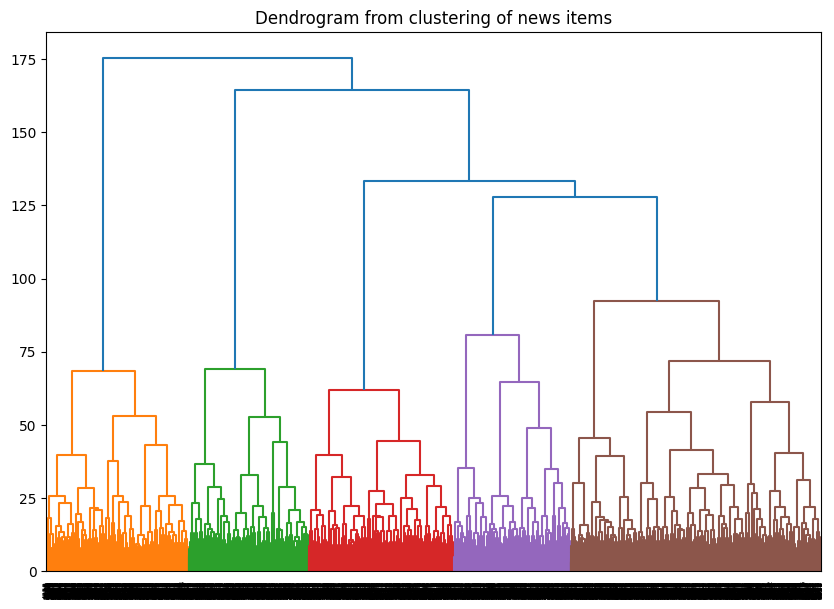

In [25]:
news_dist = 1 - news_similarities
ward_linkage = shc.linkage(news_dist, method='ward')

plt.figure(figsize=(10, 7))
shc.dendrogram(ward_linkage)
plt.title('Dendrogram from clustering of news items')
plt.show()

Denodrogram suggests any number between 3 and 6 clusters as a potential solution, so we need additional indicators to make the decision

### Use silhouette to compare alternative clustering options

There is a variety of measures used for estimating the quality of a clustering solution and comparing alternative solutions. A frequently used one is *silhouette score*, which indicates how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from −1 to +1, with a high value indicating that an instance is well matched to its own cluster and poorly matched to neighboring clusters; negative values suggest the opposite.

To determine the optimal number of clusters, we will identify cluster assignments for different number of clusters (3 - 6) and for each one compute average silhouette score across all observations; the one with the highest score will be chosen.

In [26]:
silhouette_scores = []

for k in range(3, 7):
  # fcluster identifies a specific clustering from the linkage matrix and the given number of clusters
  agg_clust = shc.fcluster(ward_linkage, t=k, criterion='maxclust')
  # Ensure no distance value is less than 0.0;
  # added to fix an issue with very tiny negative values that prevented further use of the distance matrix
  news_dist_clipped = np.clip(news_dist, a_min=0.0, a_max=None)
  sil_score = silhouette_score(news_dist_clipped, agg_clust, metric='precomputed')
  silhouette_scores.append(sil_score)

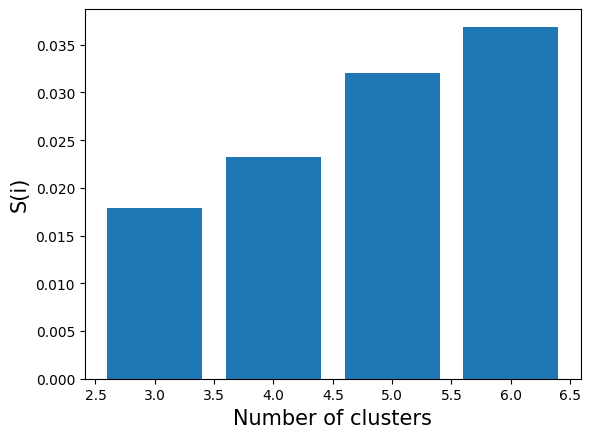

In [27]:
# Plotting a bar graph to compare the results
plt.bar(range(3, 7), silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 15)
plt.ylabel('S(i)', fontsize = 15)
plt.show()

Silhouette scores suggest 6 clusters as the best solution. Let's examine how large and balanced the clusters are:

In [28]:
agg_6_clust = shc.fcluster(ward_linkage, t=6, criterion='maxclust')
pd.Series(agg_6_clust).value_counts()

,count
6,1181
3,938
1,922
2,774
4,752
5,433


This is not perfect - there is one very small cluster, but from the dendrogram, it would be present regardless of the (meaningful) number of clusters we choose.

### Optional: Use t-SNE to reduce the dimensionality of news representation and visualise cluster assignments

We will use a dimensionality reduction method to reduce the dimensionality of the news representation, so that we can visually explore distinct clustering solutions.

t-SNE is a dimensionality reduction technique that is often used for exploration of high-dimensional data. The main advantage of t-SNE is its ability to preserve local structure in the data, meaning that points that are close to one another in a high-dimensional dataset will still be close to one another in the (dimensionaly) reduced dataset and if the new dataset is 2-dimensional and plotted, they will be close to one another in the plot.

We will use t-SNE here to reduce the *news_embeddings* data from 384 dimensions to 2 dimensions and plot news items across distinct cluster assignments

In [45]:
tsne = TSNE(n_components=2,
            perplexity=20, # key argument for fine-tuning, see below
            max_iter=1500,
            metric='cosine',
            verbose=1,
            random_state=RAND_STATE)

z = tsne.fit_transform(news_embeddings)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 1.217s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.222742
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.244827
[t-SNE] KL divergence after 1500 iterations: 1.990261


Note: *perplexity* is one of the key paramters for fine-tuning dimensionality reduction done by t-SNE since it determines if we care more about the local structure of the data or a 'big-picture': a low perplexity means we care about local scale and focus on the closest points; high perplexity takes more of a "big picture" approach. Recommended values are in the 5-50 range, and default is 30. We will use here the default value and you may want to experiment with higher / lower values to explore how the visualisations and patterns in the data change.

In [30]:
z.shape

(5000, 2)

Now that we have the news content as 2-dimensional vectors, we can add cluster assignments and plot them

In [46]:
reduced_embeddings_df = pd.DataFrame()
reduced_embeddings_df["comp-1"] = z[:,0]
reduced_embeddings_df["comp-2"] = z[:,1]
reduced_embeddings_df['clust'] = agg_6_clust

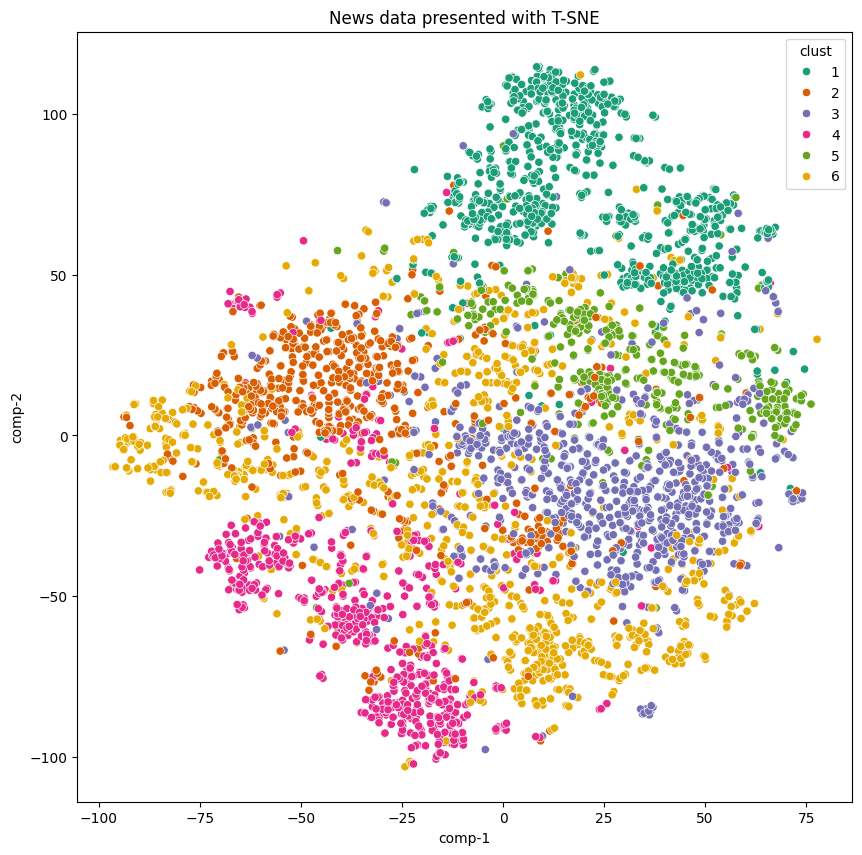

In [47]:
plt.figure(figsize=(10,10))
sb.scatterplot(x='comp-1', y='comp-2', data=reduced_embeddings_df, hue='clust', palette='Dark2')
plt.title("News data presented with T-SNE")
plt.show()

If interested in learning how to fine tune t-SNE to get an optimal 2D representation of data, [this blog post](https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/) might be a good point to start from.

We will try to better understand the clusters by associating them with keywords.

### Characterise clusters by their keywords

To get an idea what each cluster is about, we will extract keywords from each cluster and use them to characterise the clusters.

In particular, we will use [KeyBERT](https://github.com/MaartenGr/KeyBERT) for keywords extraction. For an overview of other options, see, for example, [this article](https://www.analyticsvidhya.com/blog/2022/01/four-of-the-easiest-and-most-effective-methods-of-keyword-extraction-from-a-single-text-using-python/)

In brief, KeyBERT works as follows (see it illustrated on [this page](https://maartengr.github.io/KeyBERT/guides/quickstart.html)):
* First, documents are split into tokens and tokens are filtered to keep those that are solid candidates for keywords; the filtering typically consists of excluding stop-words and keeping words with some minimal TF and/or DF values  
* Then, document embeddings are created using a pretrained Sentente Embeddings model (typically, a BERT-based model from the HuggingFace repo), to get a document-level vectors; likewise, the same embedding model is used to create embeddings of the candidate keywords.
* Finally, cosine similarity is used to find the words/phrases that are the most similar to each document. The most similar words/phrases are identified as those that best describe the entire document.



In [36]:
from keybert import KeyBERT

kw_model = KeyBERT(model=PRETRAINED_LM)

In [37]:
df = pd.DataFrame()
df = pd.concat([df, data2024['content'], reduced_embeddings_df['clust']], axis=1)
df.head()

,content,clust
0,Train strikes: What routes are affected when?....,6
1,'I'm not Harry Potter' - Ten Hag defends Man U...,1
2,Thousands more appointments hit by doctor stri...,6
3,"Labour manifesto all about wealth creation, sa...",2
4,In defence of Foden - 'this is a tactical issu...,1


Merge documents within each cluster and then determine keywords for each cluster

In [38]:
n_clust = df.clust.nunique()
clusters_text = []
for i in range(1, n_clust+1):
  clust_txt = " ".join(df.loc[df.clust == i,'content'].tolist())
  clusters_text.append(clust_txt)

clusters_keywords = []
for i in range(n_clust):
  clust_keywords = kw_model.extract_keywords(clusters_text[i],
                                             keyphrase_ngram_range=(1, 2),
                                             stop_words='english',
                                             top_n=10,
                                             use_mmr=True, diversity=0.5) #use Maximal Margin Relevance (MMR) to diversify the results
  for clust_kw in clust_keywords:
    kw, score = clust_kw
    clusters_keywords.append({'cluster':i+1, 'keyword':kw, 'score':score})

In [39]:
cl_keywords_df = pd.DataFrame(clusters_keywords)
cl_keywords_df.head()

,cluster,keyword,score
0,1,potter hag,0.5441
1,1,criticises manchester,0.4950
2,1,challenging gatland,0.4284
3,1,tottenham defeat,0.3900
4,1,manager thomas,0.3893


In [40]:
cl_keywords_df.sort_values(by=['cluster','score'], inplace=True)
# cl_keywords_df.head(10)

Present the keywords and their scores visually

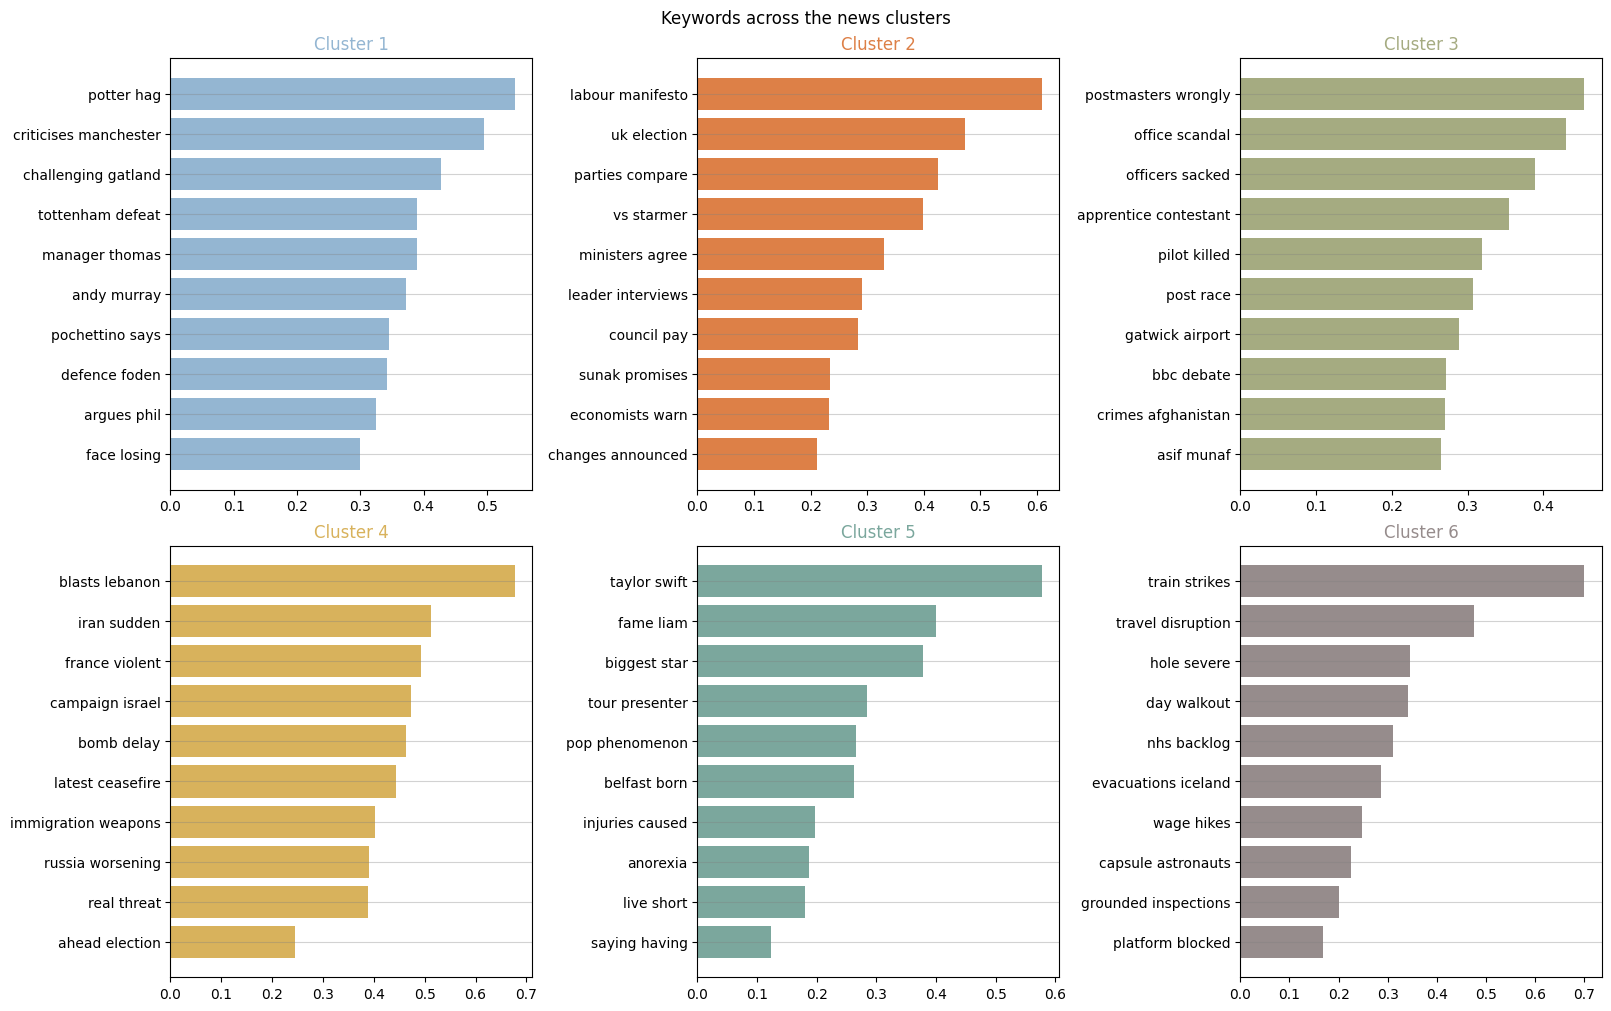

In [41]:
fig, ax_grid = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), constrained_layout=True)
axes = ax_grid.flatten()

cmap = load_cmap("excel_Median")

for i in range(n_clust):

    df = cl_keywords_df.loc[cl_keywords_df.cluster == (i+1),]
    scores = df.score.tolist()
    keywords = df.keyword.tolist()

    axes[i].barh(keywords, scores, color=cmap(i))
    axes[i].set_title(f"Cluster {i+1}", color=cmap(i))
    axes[i].grid(visible=True, axis='y', color='gray', alpha=0.35)

fig.suptitle("Keywords across the news clusters")

plt.show()
